# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Drop a column feature


# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pylab import rcParams
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')   

# What is the goal?
<hr style="border:2px solid black"> </hr>


- **IN SHORT?** It is shown that the impurity-based feature importance can inflate the importance of numerical features.
- **ARGUMENT?** The impurity-based feature importance of random forests suffers from being computed on statistics derived
from the training dataset: the importances can be high even for features that are not predictive of the target 
variable, as long as the model has the capacity to use them to overfit. The impurity-based feature importance ranks 
the numerical features to be the most important features. This problem stems from two limitations of impurity-based 
feature importances:
- **[1]** impurity-based importances are biased towards high cardinality features;
- **[2]** impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).
- **SOLUTION?** Use Permutation Importances



# Load dataset
<hr style="border:2px solid black"> </hr>

In [4]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [5]:
X.head(3)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [6]:
y.head(3)

0    1
1    1
2    0
Name: survived, dtype: category
Categories (2, object): ['0', '1']

# Feature engineering
<hr style="border:2px solid black"> </hr>


- Feature engineering bacause we are adding some. Since our goal is to show the effect of cardinality on the extraction of feature based on impurity coefficient we artificially create two of them that have both high and low CARDINALITY.
- We further include two random variables that are not correlated in any way with the target variable (survived):
- **[1]** random_num is a HIGH cardinality numerical variable (as many unique values as records).
- **[2]** random_cat is a LOW cardinality categorical variable (3 possible values).



In [8]:
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])
import copy
XX = copy.deepcopy(X)

In [9]:
X.head(3)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,random_cat,random_num
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",2,-1.110576
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1.752270
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",2,0.935678


# Data pre-processing
<hr style="border:2px solid black"> </hr>


- The following shows how to apply separate preprocessing on numerical and categorical features. 



In [11]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')

numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [12]:
# We are left with the following dataset
X.head(3)

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
0,1.0,female,S,2,29.0000,0.0,0.0,211.3375,-1.110576
1,1.0,male,S,0,0.9167,1.0,2.0,151.5500,1.752270
2,1.0,female,S,2,2.0000,1.0,2.0,151.5500,0.935678


# Fit the baseline (no hyperparameters tuning) model
<hr style="border:2px solid black"> </hr>

In [13]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [14]:
print("Train accuracy: %0.3f" % rf.score(X_train, y_train))
print("Test accuracy: %0.3f" % rf.score(X_test, y_test))

Train accuracy: 1.000
Test accuracy: 0.817



- Here one can observe that the train accuracy is very high (the forest model has enough capacity to completely memorise the training set) but it can still generalize well enough to the test set thanks to the built-in bagging of random forests. 
- It might be possible to trade some accuracy on the training set for a slightly better accuracy on the test set by limiting the capacity of the trees (for instance by setting min_samples_leaf=5 or min_samples_leaf=10) so as to limit overfitting while not introducing too much underfitting. 



# Tree’s Feature Importance from Mean Decrease in Impurity (MDI)
<hr style="border:2px solid black"> </hr>


- The impurity-based feature importance ranks the numerical features to be the most important features!
- This is not very useful indeed. The "What is the goal?" section explains why this is happening.



In [17]:
ohe = (rf.named_steps['preprocess'].named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

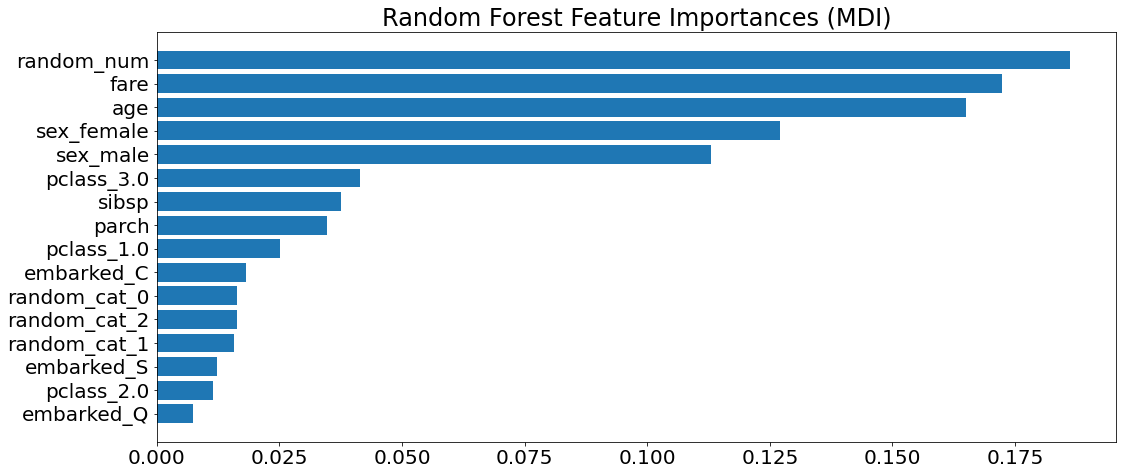

In [18]:
rcParams['figure.figsize'] = 16, 7
rcParams['font.size'] = 20
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

# Permutation importance on test set
<hr style="border:2px solid black"> </hr>


- This shows that the low cardinality categorical feature, sex is the most important feature. 
- Also note that both random features have very low importances (close to 0) as expected. 
- **CARDINALITY** express how many uniques values are present.



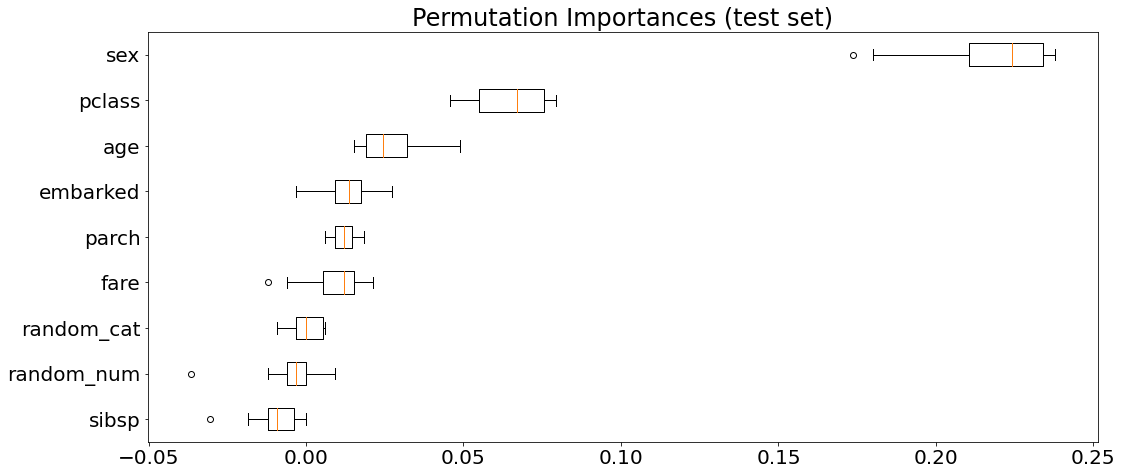

In [20]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


- This shows that the low cardinality categorical feature, sex is the most important feature.
- Also note that both random features have very low importances (close to 0) as expected.



# Permutation importance on training test
<hr style="border:2px solid black"> </hr>


- It is also possible to compute the permutation importances on the **training set**.
- This reveals that random_num gets a significantly higher importance ranking than when computed on the test set. 
- The difference between those two plots is a confirmation that the model has enough capacity to use that random numerical feature to overfit. 



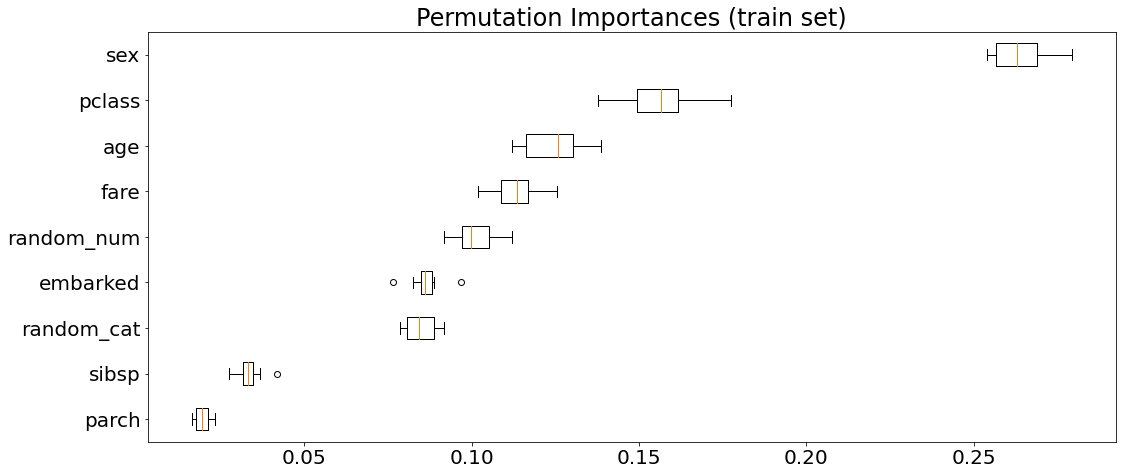

In [23]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

# Cardinality
<hr style="border:2px solid black"> </hr>


- Definition of cardinality: how many distinct values are present?
- You generality aims for high cardinality for each feature.
- If cardinality is too low you have many ducplicates in your daraset, so you waste resources.



In [25]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']
allColumns = categorical_columns + numerical_columns

print("Total number of values: ", X.shape)

cardinalityDict = {}
for feature in allColumns:
    setValues = set(X[feature])
    cardinalityDict[feature] = len(setValues)
    #print("Cardinality of " + feature, len(setValues))    

Total number of values:  (1309, 9)


In [26]:
sortedCaridinalityDict = sorted(cardinalityDict.items(), key=lambda x: x[1], reverse=True)

In [27]:
for item in sortedCaridinalityDict:
    print(item)

('random_num', 1309)
('age', 361)
('fare', 282)
('parch', 8)
('sibsp', 7)
('embarked', 4)
('pclass', 3)
('random_cat', 3)
('sex', 2)


# Drop Column feature importance
<hr style="border:2px solid black"> </hr>


- This approach is quite simple. 
- We get the ranked features importance and we remove each feature while training the model. 
- In this way we check if the ranking has an importance as big as the one suggested by the model.



In [29]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

In [30]:
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,random_cat,random_num
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",2,-1.110576
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1.752270
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",2,0.935678
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",2,1.271555
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0,0.721672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None,2,-0.971657
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None,2,-1.379618
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None,1,-0.626717
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None,1,0.862393


In [31]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
#categorical_columns = ['sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

preprocessing = ColumnTransformer(
    [('categorical', categorical_encoder, categorical_columns),
     ('numerical', numerical_pipe, numerical_columns)])
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)
benchmark_score = rf.score(X_train, y_train)
print(benchmark_score)

1.0


In [32]:
X

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
0,1.0,female,S,2,29.0000,0.0,0.0,211.3375,-1.110576
1,1.0,male,S,0,0.9167,1.0,2.0,151.5500,1.752270
2,1.0,female,S,2,2.0000,1.0,2.0,151.5500,0.935678
3,1.0,male,S,2,30.0000,1.0,2.0,151.5500,1.271555
4,1.0,female,S,0,25.0000,1.0,2.0,151.5500,0.721672
...,...,...,...,...,...,...,...,...,...
1304,3.0,female,C,2,14.5000,1.0,0.0,14.4542,-0.971657
1305,3.0,female,C,2,NaN,1.0,0.0,14.4542,-1.379618
1306,3.0,male,C,1,26.5000,0.0,0.0,7.2250,-0.626717
1307,3.0,male,C,1,27.0000,0.0,0.0,7.2250,0.862393


In [33]:
def dropColumnFeatureImportance(X, y, benchmark_score, random_state=42):

    deltaScore = []
    # iterating over all columns and storing feature importance (difference between benchmark and new model)

    categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
    numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

    for col in X.columns:
        print("Dropping feature name: ", col, type(col))

        # =================
        if col in categorical_columns:
            where = categorical_columns.index(col)
            categorical_columns.pop(where)
        elif col in numerical_columns:
            where = numerical_columns.index(col)
            numerical_columns.pop(where)
        print(categorical_columns + numerical_columns)

        X = X[categorical_columns + numerical_columns]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.8, random_state=42)

        categorical_encoder = OneHotEncoder(handle_unknown='ignore')

        numerical_pipe = Pipeline(
            [('imputer', SimpleImputer(strategy='mean'))])

        preprocessing = ColumnTransformer(
            [('categorical', categorical_encoder, categorical_columns),
             ('numerical', numerical_pipe, numerical_columns)])

        rf = Pipeline([
            ('preprocess', preprocessing),
            ('classifier', RandomForestClassifier(random_state=42))
        ])

        # =================

        rf.fit(X_train, y_train)
        drop_col_score = rf.score(X_train, y_train)
        drop_col_score1 = rf.score(X_test, y_test)
        print(drop_col_score)
        print(drop_col_score1)
        #print(benchmark_score - drop_col_score)
        deltaScore.append(benchmark_score - drop_col_score1)

        X, y = fetch_openml("titanic", version=1,
                            as_frame=True, return_X_y=True)
        rng = np.random.RandomState(seed=42)
        X['random_cat'] = rng.randint(3, size=X.shape[0])
        X['random_num'] = rng.randn(X.shape[0])
        categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
        numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

    return deltaScore

In [34]:
deltaScore = dropColumnFeatureImportance(X, y, benchmark_score, random_state = 42)

Dropping feature name:  pclass <class 'str'>
['sex', 'embarked', 'random_cat', 'age', 'sibsp', 'parch', 'fare', 'random_num']
1.0
0.7652671755725191
Dropping feature name:  sex <class 'str'>
['pclass', 'embarked', 'random_cat', 'age', 'sibsp', 'parch', 'fare', 'random_num']
1.0
0.6889312977099237
Dropping feature name:  embarked <class 'str'>
['pclass', 'sex', 'random_cat', 'age', 'sibsp', 'parch', 'fare', 'random_num']
1.0
0.7748091603053435
Dropping feature name:  random_cat <class 'str'>
['pclass', 'sex', 'embarked', 'age', 'sibsp', 'parch', 'fare', 'random_num']
1.0
0.7729007633587787
Dropping feature name:  age <class 'str'>
['pclass', 'sex', 'embarked', 'random_cat', 'sibsp', 'parch', 'fare', 'random_num']
1.0
0.7595419847328244
Dropping feature name:  sibsp <class 'str'>
['pclass', 'sex', 'embarked', 'random_cat', 'age', 'parch', 'fare', 'random_num']
1.0
0.7776717557251909
Dropping feature name:  parch <class 'str'>
['pclass', 'sex', 'embarked', 'random_cat', 'age', 'sibsp', 'f

<AxesSubplot:xlabel='deltaScore', ylabel='feature'>

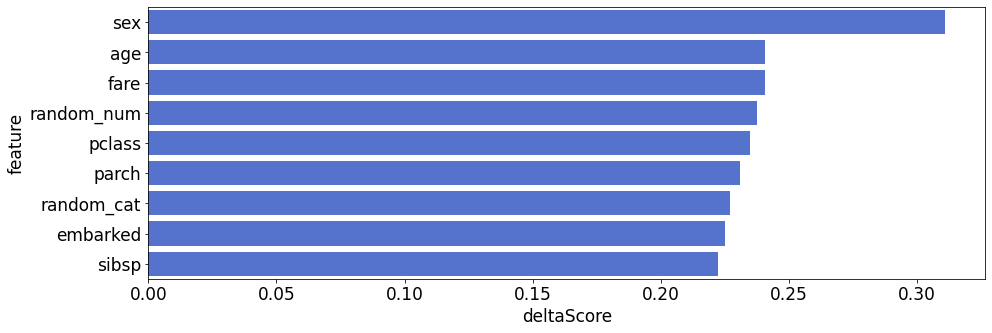

In [35]:
# Create a pandas dataframe which helps to sort via ascending order
df2 = pd.DataFrame({'feature': X_train.columns,
                   'deltaScore': deltaScore}) \
       .sort_values('deltaScore', ascending = False) \
       .reset_index(drop = True)
    
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 17


#df2.columns = ['feature', 'deltaScore']
sns.barplot(x = 'deltaScore', y = 'feature', data = df2, orient = 'h', color = 'royalblue')


- Attention: the differences could have seen only on the test set, not in the training set. 
- Apparetnly in the training set even if I remove each one at the time I still get training accuracy to 100%. 
- I have the feeling I am overfitting the model.



# References
<hr style="border:2px solid black"> </hr>


- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
- https://orangematter.solarwinds.com/2020/01/05/what-is-cardinality-in-a-database/
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

